# Group 6
- Dang Luong - BS20DSY034
- Ngoc Duong - BS20DSY024
- Armaan Dhar - BS20DMU009
- Kushal Jain - BS20DMU007


### **Import Libraries**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
!unzip gdrive/My\ Drive/Rice_Image_Dataset.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (551).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5510).jpg  
  inflating: Rice_Image_Dataset/Karac

In [4]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

### **Dataset preparing**
Split-folders library was used to split the dataset into three parts: Training set(80%), Validation set(10%), and Test set(10%).

In [6]:
base_ds = 'Rice_Image_Dataset'
base_ds = pathlib.Path(base_ds)

In [7]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.7,.15,.15), group_prefix=None)

Copying files: 75000 files [00:13, 5614.34 files/s]


In [8]:
arborio = [fn for fn in os.listdir(f'{base_ds}/Arborio') if fn.endswith('.jpg')]
bastmati = [fn for fn in os.listdir(f'{base_ds}/Basmati') if fn.endswith('.jpg')]
ipsala = [fn for fn in os.listdir(f'{base_ds}/Ipsala') if fn.endswith('.jpg')]
jasmine = [fn for fn in os.listdir(f'{base_ds}/Jasmine') if fn.endswith('.jpg')]
karacadag = [fn for fn in os.listdir(f'{base_ds}/Karacadag') if fn.endswith('.jpg')]
rice = [arborio, bastmati, ipsala, jasmine, karacadag]
rice_classes = []
for i in os.listdir('imgs/train'):
    rice_classes+=[i]
rice_classes.sort()

### **Dataset Exploration**
It can be seen here the total number of images in the dataset, the number of classes, and how well the images from each variety is distributed

Total images: 75000
Total number of classes: 5
Total Arborio images: 15000
Total Basmati images: 15000
Total Ipsala images: 15000
Total Jasmine images: 15000
Total Karacadag images: 15000


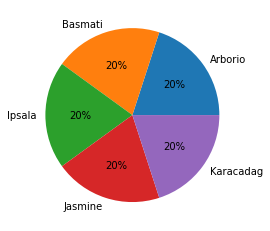

In [9]:
image_count = len(list(base_ds.glob('*/*.jpg')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(rice_classes)}')
count = 0
rice_count = []
for x in rice_classes:
  print(f'Total {x} images: {len(rice[count])}')
  rice_count.append(len(rice[count]))
  count += 1
plt.pie(rice_count,labels= rice_classes,autopct='%1.0f%%')
plt.show()

## Images

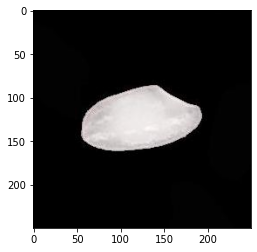

Image dimensions: (250, 250, 3)


In [10]:
sample_img = cv2.imread('imgs/test/Arborio/Arborio (10001).jpg')
plt.imshow(sample_img)
plt.show()
print(f'Image dimensions: {sample_img.shape}')

Image from the dataset has a dimension of 250x250 and RGB color

In [11]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in rice_classes:
    i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')
  plt.show()

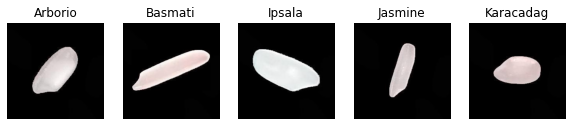

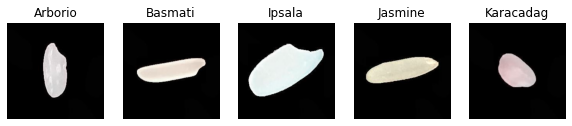

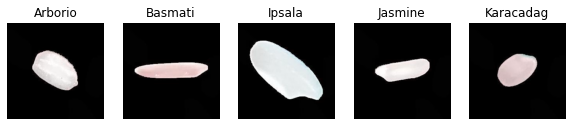

In [12]:
for i in range(3):
  load_random_img(base_ds, rice_classes)

### **Data Pre-processing**

In [13]:
#Hyparameters
batch_size = 128
img_height, img_width = 175, 175
input_shape = (img_height, img_width, 3)
epochs=40

In [14]:
datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.


### Training plotting function

In [28]:
def plot_train_history(modelx):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(modelx.history['accuracy'])
    plt.plot(modelx.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(modelx.history['loss'])
    plt.plot(modelx.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


## CNN Model
Using VGG architechture

In [17]:
model = tf.keras.Sequential([
    #CONV => RELU => CONV => RELU => POOL layer set
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    #CONV => RELU => CONV => RELU => POOL layer set
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),
    #  FC => RELU layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    # softmax classifier
    tf.keras.layers.Dense(5),
    tf.keras.layers.Activation('softmax')
])

### Tuning

In [18]:
opt = SGD(learning_rate=0.1, decay=0.01/epochs, 
          momentum=0.9, nesterov=True)
adm = Adam(learning_rate=0.1)
model.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 173, 173, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 173, 173, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 173, 173, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 173, 173, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 87, 87, 32)       0         
 )                                                               
                                                        

## **Callbacks**

In [19]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/model1.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [20]:
model1 = model.fit(train_ds, epochs = epochs, validation_data = val_ds, callbacks=callbacks)

Epoch 1/40
411/411 [==============================] - ETA: 0s - loss: 0.4711 - accuracy: 0.9180
Epoch 1: val_accuracy improved from -inf to 0.19147, saving model to saved_models/model1.hdf5
411/411 [==============================] - 208s 462ms/step - loss: 0.4711 - accuracy: 0.9180 - val_loss: 3069.4009 - val_accuracy: 0.1915 - lr: 0.1000
Epoch 2/40
411/411 [==============================] - ETA: 0s - loss: 0.5428 - accuracy: 0.9439
Epoch 2: val_accuracy improved from 0.19147 to 0.75271, saving model to saved_models/model1.hdf5
411/411 [==============================] - 186s 451ms/step - loss: 0.5428 - accuracy: 0.9439 - val_loss: 2.2270 - val_accuracy: 0.7527 - lr: 0.1000
Epoch 3/40
411/411 [==============================] - ETA: 0s - loss: 0.2327 - accuracy: 0.9673
Epoch 3: val_accuracy did not improve from 0.75271
411/411 [==============================] - 181s 440ms/step - loss: 0.2327 - accuracy: 0.9673 - val_loss: 57.2077 - val_accuracy: 0.3319 - lr: 0.1000
Epoch 4/40
411/411 [==

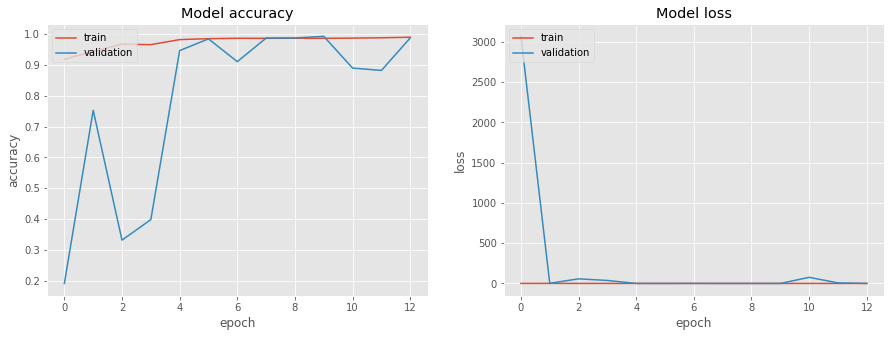

In [29]:
model.load_weights('saved_models/model1.hdf5')
plot_train_history(model1)

- With SGD optimizer, we achieved 0.987 in val-accuracy 
- With adam optimizer, we achieved 0.993 in val-accuracy and accuracy of 0.992. So we decided to use the Adam over SGD

###  Model Evaluation of simplified VGG

In [30]:
score1 = model.evaluate(test_ds, verbose=1)

88/88 [==============================] - 22s 255ms/step - loss: 0.0315 - accuracy: 0.9922


In [32]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_ds)
y_pred = np.argmax(Y_pred, axis=1)

report1 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

88/88 [==============================] - 18s 208ms/step


,precision,recall,f1-score,support
Arborio,0.986259,0.988889,0.987572,2250.000000
Basmati,0.996864,0.988889,0.992860,2250.000000
Ipsala,1.000000,0.997333,0.998665,2250.000000
Jasmine,0.986356,0.996000,0.991154,2250.000000
Karacadag,0.991541,0.989778,0.990658,2250.000000
accuracy,0.992178,0.992178,0.992178,0.992178
macro avg,0.992204,0.992178,0.992182,11250.000000
weighted avg,0.992204,0.992178,0.992182,11250.000000


### VGG16 achitecture

In [33]:
#Using the VGG16 achitechture
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
vgg16.trainable = False
inputs = tf.keras.Input(input_shape)
x = vgg16(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)
model_vgg16 = tf.keras.Model(inputs, x)

58889256/58889256 [==============================] - 4s 0us/step


In [34]:
model_vgg16.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 175, 175, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 15,245,125
Trainable params: 530,437
Non-trainable params: 14,714,688
___________________________________________

In [35]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_vgg16.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [36]:
model2 = model_vgg16.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

Epoch 1/40
411/411 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9455
Epoch 1: val_accuracy improved from -inf to 0.98649, saving model to saved_models/model_vgg16.hdf5
411/411 [==============================] - 218s 511ms/step - loss: 0.2197 - accuracy: 0.9455 - val_loss: 0.0443 - val_accuracy: 0.9865 - lr: 0.0040
Epoch 2/40
411/411 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9879
Epoch 2: val_accuracy improved from 0.98649 to 0.99013, saving model to saved_models/model_vgg16.hdf5
411/411 [==============================] - 201s 487ms/step - loss: 0.0392 - accuracy: 0.9879 - val_loss: 0.0323 - val_accuracy: 0.9901 - lr: 0.0040
Epoch 3/40
411/411 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9887
Epoch 3: val_accuracy did not improve from 0.99013
411/411 [==============================] - 198s 482ms/step - loss: 0.0322 - accuracy: 0.9887 - val_loss: 0.0362 - val_accuracy: 0.9884 - lr: 0.0040
Epoch 4/40
411/4

In [37]:
model_vgg16.load_weights('saved_models/model_vgg16.hdf5')

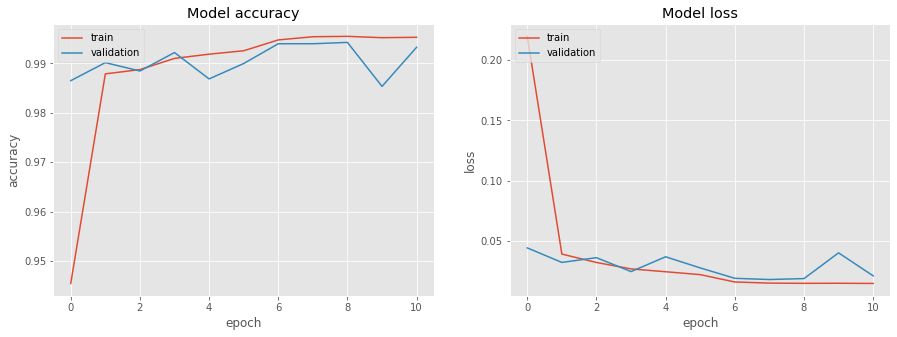

In [38]:
plot_train_history(model2)

## **Final Evaluation**

In [39]:
score2 = model_vgg16.evaluate(test_ds, verbose=1)
print(f'Model 1 Simplified VGG Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 VGG16 Loss: {score2[0]}, Accuracy: {score2[1]*100}')

88/88 [==============================] - 37s 417ms/step - loss: 0.0182 - accuracy: 0.9939
Model 1 Simplified VGG Loss: 0.03146820515394211, Accuracy: 99.21777844429016
Model 2 VGG16 Loss: 0.018159782513976097, Accuracy: 99.38666820526123


- The Simplified VGG achieve 99.218% accuracy for the test set while the VGG16 is 99.387%

In [40]:
Y_pred = model_vgg16.predict(test_ds)

88/88 [==============================] - 39s 439ms/step


In [41]:
report2 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)
df2 = pd.DataFrame(report1).transpose()
df2

,precision,recall,f1-score,support
Arborio,0.986259,0.988889,0.987572,2250.000000
Basmati,0.996864,0.988889,0.992860,2250.000000
Ipsala,1.000000,0.997333,0.998665,2250.000000
Jasmine,0.986356,0.996000,0.991154,2250.000000
Karacadag,0.991541,0.989778,0.990658,2250.000000
accuracy,0.992178,0.992178,0.992178,0.992178
macro avg,0.992204,0.992178,0.992182,11250.000000
weighted avg,0.992204,0.992178,0.992182,11250.000000


- The two model is nearly 99.5% correct in classifying grain, which is a really high result. Infact the VGG16 still do the job better than the Simplified VGG a little bit. But it is undeniable that these are very good model.
- In reality while classifying the grain, they will use a group of many grain with same type, not just only 1 seed, so the 2 model can be used practically.

